<a href="https://colab.research.google.com/github/WojteckiQ/python_assignement/blob/main/Test_Python_NEOEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%pip install ortools
#%pip install pysftp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, json
#import pysftp
import seaborn as sns
from io import BytesIO
from datetime import datetime, timedelta
#from ortools.linear_solver import pywraplp
from bs4 import BeautifulSoup
import warnings
from google.colab import userdata
import time
import polars as pl
from datetime import datetime, timedelta, timezone
import os
print("Current directory : ",os.getcwd())

Current directory :  /content


# Exercise Analyst : BE Intraday
With the parquet file "idm_trades.pq" that gathers all IDC transactions from Belgium, compute the VWAP (1H) of all hourly product from Intraday Continuous Trades from 2022-01-01 to 2022-06-01. Please, remove self-trade of datasets before computing the ID.

We assume that the product is illiquid 1h before its delivery. Then computation is done from H-2 to H-1.

ENTSOE Mapcode :
"10YBE----------2" = Belgium

Example :
- Trades

| Volume | Price     | Delivery | Execution | Product | Self-Trade | BE  |
| ------ | --------- | -------- | --------- | ------- | ---------- | --- |
| 1 MW   | 100 €/MWh | 17:00    | 15:43     | Hourly  | No         | Yes |
| 2 MW   | 50 €/MWh  | 17:00    | 15:57     | Hourly  | No         | Yes |

Computed on trades from 15h00 to 16h00 :
- VWAP (1h) - 17h = 66 €/MWh


In [ ]:
idc_trades = pl.read_parquet("idm_trades.pq")
idc_trades

contract__dlvry_start,contract__dlvry_end,qty_mwh,price_eurpmwh,buy_dlvry_area_id,sell_dlvry_area_id,self_trade,trade_id,contract_id,trade_time
"datetime[ns, UTC]","datetime[ns, UTC]",f64,f64,str,str,str,i64,i64,"datetime[ns, UTC]"
2021-12-28 02:00:00 UTC,2021-12-28 03:00:00 UTC,32.0,35.249388,"""10YDE-RWENET---I""","""10YBE----------2""","""false""",1233553276,12625808,2021-12-27 21:34:33.195 UTC
2022-04-27 21:00:00 UTC,2022-04-27 22:00:00 UTC,11.0,196.633022,"""10YBE----------2""","""10YBE----------2""","""false""",1270824945,12821963,2022-04-27 19:43:36.574 UTC
2022-07-06 02:00:00 UTC,2022-07-06 03:00:00 UTC,20.0,293.077265,"""10YNL----------L""","""10YBE----------2""","""false""",1294169446,12934635,2022-07-06 00:31:57.448 UTC
2022-07-23 00:00:00 UTC,2022-07-23 01:00:00 UTC,1.0,363.895766,"""10YBE----------2""","""10YBE----------2""","""false""",1300094683,12962484,2022-07-22 22:45:05.001 UTC
2022-12-11 11:00:00 UTC,2022-12-11 12:00:00 UTC,15.0,397.922901,"""10YBE----------2""","""10YDE-RWENET---I""","""false""",1354087138,13142271,2022-12-11 09:54:01.330 UTC
…,…,…,…,…,…,…,…,…,…
2022-11-22 21:00:00 UTC,2022-11-22 22:00:00 UTC,1.0,162.338669,"""10YNL----------L""","""10YBE----------2""","""false""",1346185880,13123910,2022-11-22 16:45:49.142 UTC
2022-12-24 09:00:00 UTC,2022-12-24 10:00:00 UTC,6.0,165.211431,"""10YDE-EON------1""","""10YBE----------2""","""false""",1360191037,13155524,2022-12-24 05:14:26.250 UTC
2021-11-14 18:00:00 UTC,2021-11-14 19:00:00 UTC,32.0,217.968117,"""10YBE----------2""","""10YAT-APG------L""","""false""",1221497582,12555810,2021-11-14 06:44:06.095 UTC


### Warm-up

Write a program to sum all positive integers up to and including $n$. Then, summing for all odd integers

Ecrire un programme qui réalise la somme des entiers positifs, jusqu'au nombre $n$ inclus.
Puis de même, en sommant pour tous les entiers impairs

In [ ]:
def cum_sum_int(n):
    return sum(np.arange(1,n+1))

def cum_sum_int_odd(n):
  return sum(np.arange(1,n+1)[::2])



In [ ]:
#Output expected
print(cum_sum_int(100))
# 5050

print(cum_sum_int_odd(100))
# 2500

5050
2500


### Exercice 1

*Write* a function that inverts an integer (positive or negative), i.e. it takes as input an integer -6523, for example, and returns as output the inverted integer -3256.

> Ajouter une citation



Ecrire une fonction qui inverse un entier (positif ou négatif), c’est-à-dire qu'elle  prend en entrée un entier -6523 par exemple et retourne en sortie l’entier inversé -3256.

In [ ]:
# WRITE CODE HERE
def reverse_int(number):
    return np.sign(number)*int(str(abs(number))[::-1])

In [ ]:
print(reverse_int(2020))
#Expected 202

print(reverse_int(-9430))
#Expected -349

print(reverse_int(-6523))
#Expected -3256

202
-349
-3256


### Exercise 2

Recall that the Fibonacci sequence is given by $u_{n} = u_{n-1} + u_{n-2}$ with $u_0 = 1$ and $u_1 = 1$. Write a function that calculates the Fibonacci numbers between two integers $a \leq b$. An intermediate function may help.

On rappelle que la suite de Fibonacci est donnée par $u_{n} = u_{n-1} + u_{n-2}$ avec $u_0 = 1$ et $u_1 = 1$. Ecrire une fonction qui calcule les nombres de Fibonacci compris entre deux entiers $a \leq b$. on pourra s'aider d'une fonction intermédiaire.

In [10]:
## QW

def fibonacci(number : int):
  """
  Calculates the Fibonacci numbers between two integers a and b.
  Parameters :
  - a : first integer
  Returns :
  - result : result of fibonacci calculation
  """
  assert number >= 0, "a must be positive"
  if number <= 1:
    result = 1
  else:
    result = fibonacci(number-1) + fibonacci(number-2)
  return result

  fibonacci(10)

In [ ]:
## BD

## WRITE CODE HERE
def fibo_sub(a,b):
  assert a<= b
  return fibo(b)[len(fibo(a)):]

def fibo(a):
  assert a>= 1
  ll = [0,1]
  while ll[-1] <= a:
    ll += [ll[-2]+ll[-1]]
  return ll[:-1]

print(fibo(10))
print(fibo(50))
print(fibo_sub(10,50))

[0, 1, 1, 2, 3, 5, 8]
[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
[13, 21, 34]


### Exercice 3

This exercise brings together several basic questions relating to Python's pandas library.

- Replace the two **diagonals** in the following DataFrame with 0s


Cet exercice rassemble plusieurs questions basiques relatives à la bibliothèque pandas de Python.

- Remplacer les deux **diagonales** du DataFrame suivant par des 0

In [ ]:
#Input
df = pd.DataFrame(np.random.randint(1,100, 100).reshape(10, -1))
for ii in range(10):
  df.iloc[ii,ii] = 0
  df.iloc[ii,-(ii+1)] = 0


In [ ]:
print(df)

    0   1   2   3   4   5   6   7   8   9
0   0  93  13  64   8  69  20  97  28   0
1  18   0  53  98  24  92  95  31   0  92
2  51  56   0  32  70  58  67   0  31  18
3  82  27  17   0  73  38   0  13  65  59
4  50  85  72   3   0   0   3  91  81  46
5  60  93  62  38   0   0  89  93  74  61
6  13  38  43   0  13  43   0  40  93  52
7  27  74   0  49  78  31  70   0   6   8
8  90   0  62  29  89  85  60  75   0  34
9   0   6  27  98  61  36  90  20  26   0


- Join the following two DataFrame per fruit 'fruit-pazham' and 'weight-kilo'.

- Joindre les deux DataFrame suivants par fruits ‘fruit-pazham’ et ‘weight-kilo’.

In [ ]:
df1 = pd.DataFrame({'fruit': ['apple', 'banana', 'orange'] * 3,
                    'weight': ['high', 'medium', 'low'] * 3,
                    'price': np.random.randint(0, 15, 9)})

df2 = pd.DataFrame({'pazham': ['apple', 'orange', 'pine'] * 2,
                    'kilo': ['high', 'low'] * 3,
                    'price': np.random.randint(0, 15, 6)})

In [ ]:
# WRITE CODE HERE
dg = df1.merge(df2,how='outer',left_on=['fruit','weight'],right_on=['pazham','kilo'])



- Create two additional columns for this DataFrame: one similar to column 'a' shifted down one cell, and the other similar to column 'b' shifted up one cell.

- Créer deux colonnes additionnelles à ce DataFrame: l'une doit etre similaire à la colonne 'a' décalée d'une cellule vers le bas, et l'autre similaire à la colonne 'b' décalée d'une cellule vers le haut.

In [ ]:
dg['price_x_shift_1'] = dg['price_x'].shift(1)
dg['price_y_shift_m1'] = dg['price_y'].shift(-1)
print(dg)

     fruit  weight  price_x  pazham  kilo  price_y  price_x_shift_1  \
0    apple    high      9.0   apple  high      6.0              NaN   
1    apple    high      0.0   apple  high      6.0              9.0   
2    apple    high     12.0   apple  high      6.0              0.0   
3      NaN     NaN      NaN   apple   low      3.0             12.0   
4   banana  medium      2.0     NaN   NaN      NaN              NaN   
5   banana  medium     13.0     NaN   NaN      NaN              2.0   
6   banana  medium     13.0     NaN   NaN      NaN             13.0   
7      NaN     NaN      NaN  orange  high      2.0             13.0   
8   orange     low      0.0  orange   low      6.0              NaN   
9   orange     low      5.0  orange   low      6.0              0.0   
10  orange     low      4.0  orange   low      6.0              5.0   
11     NaN     NaN      NaN    pine  high     10.0              4.0   
12     NaN     NaN      NaN    pine   low     13.0              NaN   

    p

- From the following DataFrame: swap column 'a' and column 'c', then sort the columns in descending alphabetical order (from column 'e' to column 'a') without using the column names.

- A partir du DataFrame suivant: échanger la colonne 'a' et la colonne 'c' puis classer les colonnes par ordre alphabétique descendant (de la colonne 'e' à la colonne 'a') sans utiliser les noms des colonnes.

In [ ]:
df = pd.DataFrame(np.arange(20).reshape(-1, 5), columns=list('abcde'))
dg = df[['c','b','a','d','e']]
dh =  dg.reindex(sorted(dg.columns)[::-1], axis=1)



```
# Ce texte est au format code
```

### Exercise Fingrid


With the following function, we'll retrieve data from the Fingrid website. In particular, it provides information on the evolution of the reserve market.

Via la fonction suivante nous allons chercher des données sur le site de Fingrid. Ce dernier nous renseigne nottament sur l'évolution du marché de réserve.

In [ ]:
dic_id = {278 : 'Volume_Forecasted',
          276 : 'Volume_Procured',
          277 : 'Price'
          }
api_key_fingrid = userdata.get('api_key_fingrid')

start = "20210101"
end = "20230101"

def build_data_from_fingrid(start, end, id_features):
    """
    Fetches data from the Fingrid API for the given time range and features.

    Args:
        start (datetime): The start date and time.
        end (datetime): The end date and time.
        id_features (list): List of feature IDs to fetch data for.

    Returns:
        pandas.DataFrame: A DataFrame containing the fetched data.
    """
    if isinstance(start, str):
        start = pd.to_datetime(start)
    if isinstance(end, str):
        end = pd.to_datetime(end)

    # Format start and end dates
    dt_str1 = start.strftime('%Y-%m-%d') + 'T00:00:00Z'
    dt_str2 = end.strftime('%Y-%m-%d') + 'T00:00:00Z'

    # List to store fetched DataFrames
    list_dataf = []

    # Loop through each feature ID
    for k in id_features:

        # Construct API request URL
        stk = str(k)
        url = 'https://data.fingrid.fi/api/datasets/' + stk + '/data'

        # Set request headers and parameters
        headers = {'x-api-key': api_key_fingrid}  # 'Retry-After':'10'
        params = {'startTime': dt_str1, 'endTime': dt_str2, 'pageSize': 20000}  #'pageSize': 150

        # Send API request
        response = fetch_data_with_retry(url, headers=headers, params=params)

        # Get data from first page and total pages
        data = response["data"]
        total_pages = response['pagination']['lastPage']

        # Loop through remaining pages
        for page in range(2, total_pages + 1):
            next_url = f"{url}?page={page}"
            response = fetch_data_with_retry(next_url, headers=headers, params=params)
            data += response["data"]

        # Create DataFrame from fetched data
        fg_df = pd.DataFrame(data, index=range(len(data)))
        fg_df.rename(columns={'value': dic_id[k], 'startTime': 'Start', 'endTime': 'End'}, inplace=True)
        fg_df.drop(['datasetId'], axis=1, inplace=True)
        list_dataf.append(fg_df)

    # Check if any data was fetched
    assert len(data) != 0, f"No data available from {start} to {end}"

    # Combine DataFrames into a single DataFrame
    data = list_dataf[0]
    for df in list_dataf[1:]:
        data = data.set_index('Start').join(df.drop(['End'], axis=1).set_index('Start'), how='inner').reset_index()

    # Convert 'Start' column to datetime and drop 'End' column
    data['Start'] = pd.to_datetime(data['Start'])
    data.drop(['End'], axis=1, inplace=True)

    # Filter data to include only records before the start date
    data = data[data.Start.dt.tz_localize(None) < end]

    return data

def fetch_data_with_retry(url, headers=None, params=None):
    """
    Fetch data from the specified URL with retry logic.

    Args:
        url (str): The URL to fetch data from.
        headers (dict, optional): Headers to include in the request. Default is None.
        params (dict, optional): Parameters to include in the request. Default is None.

    Returns:
        dict: The JSON response data.

    Raises:
        Exception: If the response status code is not 200 or 429.
    """
    # Make the initial request
    response = requests.get(url, headers=headers, params=params)

    # Check if response status code is not 200
    if response.status_code != 200:
        print(f"Response status code: {response.status_code}")
        print(response.text)

        # Check if the server responds with a 429 status code (Too Many Requests)
        if response.status_code == 429:
            # Get the value of the Retry-After header, which indicates how long to wait before retrying
            retry_after = response.headers.get('Retry-After')

            # If the Retry-After header is present and contains a valid value
            if retry_after:
                # Convert the value to an integer (number of seconds)
                retry_after_seconds = int(retry_after)  # s    #int(retry_after)
                print(f'Retry after {retry_after_seconds} s')

                # Wait for the specified duration before making another request
                time.sleep(retry_after_seconds)

                # Retry the request
                response = requests.get(url, headers=headers, params=params)

        else:
            # Raise an exception for non-200 or 429 status codes
            raise Exception(f"Unexpected status code: {response.status_code}")

    # Return the JSON response data
    return response.json()

df = build_data_from_fingrid(start, end, [278 ,276, 277] )

df.head(10)


Response status code: 429
{ "statusCode": 429, "message": "Rate limit is exceeded. Try again in 1 seconds." }
Retry after 1 s
Response status code: 429
{ "statusCode": 429, "message": "Rate limit is exceeded. Try again in 1 seconds." }
Retry after 1 s


,Start,Volume_Forecasted,Volume_Procured,Price
0,2022-12-31 23:00:00+00:00,21.60000,28.19999,48.82999
1,2022-12-31 22:00:00+00:00,28.80000,38.00000,48.82999
2,2022-12-31 21:00:00+00:00,23.10000,28.30000,48.82000
3,2022-12-31 20:00:00+00:00,18.10000,25.80000,48.82000
4,2022-12-31 19:00:00+00:00,13.10000,12.69999,15.00000
5,2022-12-31 18:00:00+00:00,8.09999,8.80000,11.98000
6,2022-12-31 17:00:00+00:00,4.79999,5.50000,11.90000
7,2022-12-31 16:00:00+00:00,3.39999,5.50000,11.90000
8,2022-12-31 15:00:00+00:00,3.70000,5.50000,11.90000
9,2022-12-31 14:00:00+00:00,5.50000,9.00000,11.98000


*Q1*: The "df" Dataframe provides the time series of volumes actually purchased by Fingrid each hour, as well as the forecast of these volumes, published on D-1 . Considering this Dataframe, analyze the forecast's performance.

*Q2*: Look at the price data. Could we use volume forecasted to forecast prices as well ?

*Q1* : Le Dataframe "df" renseigne les séries temporelles de volumes effectivement achetés par Fingrid sur chaque heure, ainsi que le forecast de ces volumes, publié en J-1 . En considérant ce Dataframe, analyser les performances du forecast.

*Q2*: Avec les données de prix, peut-on construire un forecast pour les prix également avec les données de prévisions de Fingrid ?


nb_hours: 17496
Average error: -0.57
MAPE : inf
MAE : 0.7471707996113397

12.399192096774193

nb_hours: 2946
Average error: -3.3
MAPE : inf
MAE : 4.385845322471147



<ipython-input-41-286de8b4057d>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


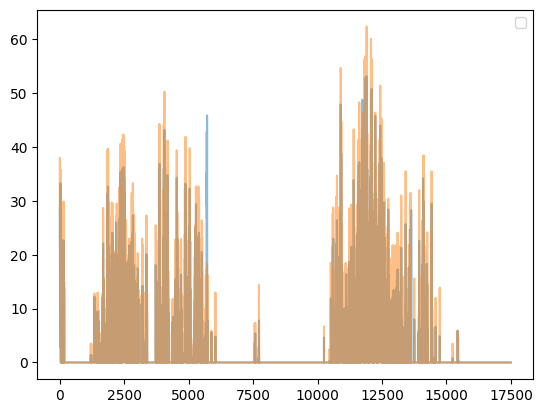

In [ ]:
print("""
nb_hours: {nb_hours}
Average error: {avg_error:.2}
MAPE : {mape:2}
MAE : {mae:2}
""".format(nb_hours = df.shape[0],
           avg_error = (df['Volume_Forecasted'] - df['Volume_Procured']).mean(),
           mape = ((df['Volume_Forecasted'] - df['Volume_Procured']).abs()/df['Volume_Procured']).mean(),
           mae = ((df['Volume_Forecasted'] - df['Volume_Procured']).abs()).mean(),
           )
)

plt.plot(df[['Volume_Forecasted','Volume_Procured']], alpha = 0.5)

dg = df.loc[df['Volume_Forecasted'] > df['Volume_Procured']]
print((dg['Volume_Forecasted'] - dg['Volume_Procured']).mean())


dh = df.loc[df['Volume_Forecasted'] != 0]
print("""
nb_hours: {nb_hours}
Average error: {avg_error:.2}
MAPE : {mape:2}
MAE : {mae:2}
""".format(nb_hours = dh.shape[0],
           avg_error = (dh['Volume_Forecasted'] - dh['Volume_Procured']).mean(),
           mape = ((dh['Volume_Forecasted'] - dh['Volume_Procured']).abs()/dh['Volume_Procured']).mean(),
           mae = ((dh['Volume_Forecasted'] - dh['Volume_Procured']).abs()).mean(),
           )
)
plt.legend()

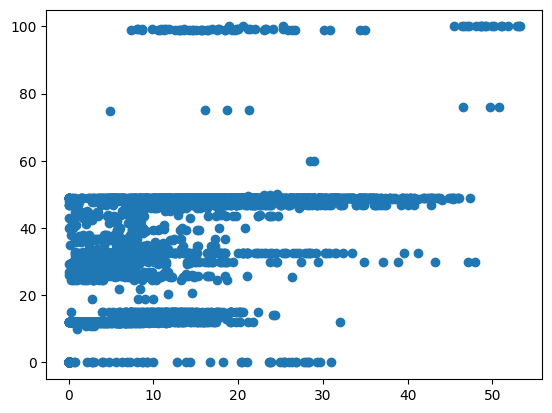

In [ ]:
plt.scatter(df['Volume_Forecasted'],df['Price'])

### Exercise 5

In [ ]:
password_entsoe = userdata.get('password_entsoe')

def collect_data_from_entsoe_stfp(file, date, date_end):
    """
    Generic function to download a csv from entsoe sftp
    """
    cnopts = pysftp.CnOpts()
    cnopts.hostkeys = None

    df = pd.DataFrame()
    result = pd.DataFrame()

    if isinstance(date, str):
        date = pd.to_datetime(date)
    if isinstance(date_end, str):
        date_end = pd.to_datetime(date_end)

    with pysftp.Connection('sftp-transparency.entsoe.eu',
                             username='market_operations@neoen.com',
                             password=password_entsoe,#'9B!6rhqFbC!iJnR?',
                             cnopts = cnopts) as sftp:

        nb_month = date_end.month - date.month + (date_end.year - date.year) * 12
        if date.month == date_end.month and date.year == date_end.year:
            flo = BytesIO()
            sftp.getfo("/TP_export/"+file+"/"+str(date.year)+"_"+\
                        str(date.month//10)+str(date.month%10)+"_"+file+".csv", flo)
            flo.seek(0)
            df = pd.read_csv(flo, sep = "\t", index_col = 0, parse_dates = True).sort_index()
            df = df[(df.index > datetime.strftime(date, format = "%Y-%m-%d %H:%M")) & \
                    (df.index < datetime.strftime(date_end, format = "%Y-%m-%d %H:%M")) ]
            result = result.append(df)
        else:
            for m in range(nb_month + 1):
                # year = date.year + (date.month + m) // 12
                # month = (date.month + m) % 12 + 1
                # if month > date_end.month and year == date_end.year:
                #     month = date_end.month

                month_file = (date.month + m)
                if month_file % 12 > 0 :
                    month = month_file % 12
                    year = date.year + month_file // 12
                elif month_file % 12 == 0:
                    year = date.year + (month_file-1) // 12
                    month = 12

                print(year, " _ ", month)
                if month < 10:
                    month = '0'+str(month)
                else :
                    month = str(month)
                flo = BytesIO()
                try :
                    sftp.getfo("/TP_export/"+file+"/"+str(year)+"_"+\
                                str(month)+"_"+file+".csv", flo)
                except:
                    print("No file for /TP_export/"+file+"/"+str(year)+"_"+\
                                str(month)+"_"+file+".csv")
                    continue
                flo.seek(0)
                df = pd.read_csv(flo,sep = "\t", index_col = 0, parse_dates = True).sort_index()
                #Conversion to UTC timezone
                df.index = df.index#.tz_localize("CET").tz_convert("UTC")
                result = pd.concat([result,df])

    return result

In [ ]:
art = "20230101"
end = "20230601"
spot = collect_data_from_entsoe_stfp("DayAheadPrices_12.1.D",
                                        start, end)
spot_fr = spot[spot.MapCode == "FR"]

In [ ]:
spot_fi = spot[spot.MapCode == "FI"]

In [ ]:
spot_fi


Over the period: "2022-01-01 00:00:00" to "2022-11-01 00:00:00" and starting from the previous dataframe, filter the following dataframe to trace only French and Finnish prices. Which of these 2 countries has the greatest volatility? If we were to invest in a storage medium (1h) between these 2 countries, which one seems more attractive, given that the round-trip yield of a battery is $\eta = 0.85$ (i.e.: calculate the capturable revenue in €/MW)?

Sur la période : "2022-01-01 00:00:00" à "2022-11-01 00:00:00" et à partir du dataframe précédent, filtrer le dataframe suivant pour ne tracer que les prix français et finlandais. Lequel de ces 2 pays a la volatilité la plus importante ? Si nous devions investir sur un moyen de stockage (1h) entre ces 2 pays, lequel semble plus attractif sachant que le rendement aller-retour d'une batterie est de $\eta = 0.85$ (i.e : calculer les revenus capturables en €/MW) ?

$Daily_{revenue} = (Price_{bought} - Price_{sold}*\eta) * Volume$

In [ ]:
### WRITE CODE HERE
#Compute daily revenues for each day and sum them, over the period



Quelles seraient les différences calculer les revenues d'une batterie de 4h ?
S'attend-on à ce qu'une batterie de 4h soit plus rentable ou moins rentable qu'une batterie de 1h, en regardant uniquement les €/MWh (indépendamment des coûts).

In [ ]:
def bess_arbitrage_case(price_origin, battery_power, battery_storage, efficiency):
    """
    Returns a dataframe of battery decision regarding its design parameters and DA prices.
    LP problem to take into account storage and energy constraint on a daily basis.
    """
    solver = pywraplp.Solver.CreateSolver('GLOP')
    price = price_origin
    price = pd.pivot_table(data = price, index = price.index.hour,
                         columns = [price.index.year, price.index.day_of_year])
    storage_ini = 0
    storage_max = battery_storage
    storage_list = [storage_ini]
    efficiency = efficiency
    battery_power = battery_power
    storage = {}
    charge = {}
    discharge = {}
    power = []
    revenues = []

    for day in range(price.shape[1]):
        #print(day, " / ",price.shape[1])
        price_temp = price.iloc[:,day]
        objective = solver.Objective()
        cycle_constraint_d = solver.RowConstraint(0, storage_max,"Cycle_constraint_1")
        cycle_constraint_c = solver.RowConstraint(0, storage_max,"Cycle_constraint_2")

        #constraints
        for h in range(24):
            charge[h] = solver.IntVar(0,battery_power,f"charge_hour_{h}")
            discharge[h] = solver.IntVar(0,battery_power,f"discharge_hour_{h}")
            storage[h] = solver.RowConstraint(-storage_ini, storage_max-storage_ini, f"storage_hour_{h}")
            cycle_constraint_c.SetCoefficient(charge[h], 1)
            cycle_constraint_d.SetCoefficient(discharge[h], 1)
            for j in range(h+1):
                storage[h].SetCoefficient(charge[j], 1)
                storage[h].SetCoefficient(discharge[j], -1/efficiency)
            objective.SetCoefficient(charge[h],-price_temp[h])
            objective.SetCoefficient(discharge[h],price_temp[h])
            objective.SetMaximization()

        solver.Solve()
        for h in range(24):
            power.append(charge[h].solution_value() - discharge[h].solution_value())
            storage_list.append(storage_list[-1] + charge[h].solution_value()*1 \
                                 - discharge[h].solution_value()/efficiency )
            revenues.append(-(charge[h].solution_value() - discharge[h].solution_value())*price_temp[h])

    df = pd.DataFrame({"storage" : storage_list[:-1], "power" : power, "revenues" : revenues,
                       "price" : price_origin.Price}, index = price_origin.index)

    return df

Use the above function to calculate the revenue for a 4-hour battery in each country. The function uses a dataframe as input, so be sure to enter a dataframe.

Utiliser la fonction ci-dessus pour calculer les revenues d'une batterie de 4h, dans chaque pays. La fonction utilise un dataframe en entrée, veillez à bien y entrer un dataframe.

In [ ]:
### FILL code
prices = spot_fr["Price"].to_frame()
bess_arbitrage_case(prices, 1, 4, 0.85)

# Bonus exercise
Collect national wind power data for Finland, using the collect_data_from_entsoe_stfp function. What can you say about the evolution of wind power plant installation over the last 5 years in Finland?

Collecter les données nationales éoliennes en Finlande, à partir de la fonction collect_data_from_entsoe_stfp. Que pouvez-vous dire de l'évolution de l'installation de centrales éoliennes sur ces 5 dernières années en Finlande ?

In [ ]:
country_code = {'FI':'10YFI-1--------U'}
token = userdata.get('token_entsoe')

def get_actual_generation_per_production_type(start,end,area,production_type):
    """
    Request via ENTSOE API and return a dataframe
    """
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    start = start.tz_localize('CET')
    start = start.tz_convert('UTC')

    end = end.tz_localize('CET')
    end = end.tz_convert('UTC')

    if (end - start).days > 300 :
        df = pd.DataFrame()
        for period in range((end - start).days // 300 + 1):

            starttime = (start+pd.to_timedelta(str(period*300)+"day")).strftime("%Y%m%d%H%M")
            if (start+pd.to_timedelta(str((2+1)*300)+"day")).tz_localize(None) < datetime.today() :
                endtime = (start+pd.to_timedelta(str((period+1)*300)+"day")).strftime("%Y%m%d%H%M")
            else :
                endtime = endtime.strftime("%Y%m%d%H%M")

            url = "https://web-api.tp.entsoe.eu/api?documentType=A75&processType=A16&psrType=" + \
                    production_type + "&in_Domain=" + country_code[area] + "&periodStart=" + \
                    starttime + '&periodEnd=' + endtime + "&securityToken="+ token
            payload = {}
            headers = {}

            response = requests.request("GET", url, headers=headers, data=payload, verify = False)
            soup = BeautifulSoup(response.text)

            position = []
            price = []
            time_UTC = []

            #the tilme step is 15 min for Belgium and Germany, and 1 hour for other countries
            if area in ['DE','DE-LU','DE-AT-LU']:
                step = 15
            else :
                step = 60

            for node in soup.find_all('timeseries'):
                #for each eligible timeseries, retrieve the start time from the xml tag
                time_init = node.find('start').text
                #convert the start time tag to a datetime object
                time_init_object = datetime.strptime(time_init,"%Y-%m-%dT%H:%MZ")

                for point in node.find_all('point'):
                    position.append(int(point.find('position').text))
                    price.append(float(point.find('quantity').text))
                    deltaminutes = (position[-1] - 1)*step
                    time_UTC.append(time_init_object + timedelta(minutes = deltaminutes))

            df_temp = pd.DataFrame(data = {'Start':time_UTC, 'Power':price})
            df_temp = df_temp[(df_temp.Start >= start.tz_localize(None) ) & (df_temp.Start < end.tz_localize(None))]
            df_temp.set_index('Start',inplace=True)

            #Clearing all duplicates because sometimes there are (Entsoe API is mad :)) Very funny Cesar
            df_temp = df_temp[~df_temp.index.duplicated(keep='first')]
            df = pd.concat([df,df_temp])
    else :
        starttime = start.strftime("%Y%m%d%H%M")
        endtime = end.strftime("%Y%m%d%H%M")

        url = "https://web-api.tp.entsoe.eu/api?documentType=A75&processType=A16&psrType=" + \
                production_type + "&in_Domain=" + country_code[area] + "&periodStart=" + \
                starttime + '&periodEnd=' + endtime + "&securityToken="+ token
        payload = {}
        headers = {}

        response = requests.request("GET", url, headers=headers, data=payload, verify = False)
        soup = BeautifulSoup(response.text)

        position = []
        price = []
        time_UTC = []

        #the tilme step is 15 min for Belgium and Germany, and 1 hour for other countries
        if area in ['DE','DE-LU','DE-AT-LU']:
            step = 15
        else :
            step = 60

        for node in soup.find_all('timeseries'):
            #for each eligible timeseries, retrieve the start time from the xml tag
            time_init = node.find('start').text
            #convert the start time tag to a datetime object
            time_init_object = datetime.strptime(time_init,"%Y-%m-%dT%H:%MZ")

            for point in node.find_all('point'):
                position.append(int(point.find('position').text))
                price.append(float(point.find('quantity').text))
                deltaminutes = (position[-1] - 1)*step
                time_UTC.append(time_init_object + timedelta(minutes = deltaminutes))

        df = pd.DataFrame(data = {'Start':time_UTC, 'Power':price})
        df = df[(df.Start >= start.tz_localize(None) ) & (df.Start < end.tz_localize(None))]
        df.set_index('Start',inplace=True)

        #Clearing all duplicates because sometimes there are (Entsoe API is mad :)) Very funny Cesar
        df = df[~df.index.duplicated(keep='first')]

    return df


In [ ]:
area = "FI"
warnings.filterwarnings("ignore")
start = "20170101"
end = "20230601"
psrType = "" #To Fill

prod = get_actual_generation_per_production_type(start, end, "FI", psrType)